In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

In [2]:
ars_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent_data_downsize/nc/20*/*int.nc'
ars_topo_path = '/home/meganmason/Documents/projects/thesis/maps/map_layers/basin_ops/tuolumne/topo/basin_setup/topo.nc'

bsu_path = '/Users/meganmason491/Documents/research/sierra/data/mm/20*/*int.nc'
bsu_topo_path = '/Users/meganmason491/Documents/research/sierra/data/topo.nc'

path = ars_path
topo_path = ars_topo_path

In [3]:
#filepath list, lidar
flist = sorted(glob.glob(path))

# Parse dates, store as pandas datetime type in list
fparse = [d.split('/')[-1] for d in flist] #splits fname on '/' saves last
fparse = [d.split('_')[0] for d in fparse] #splits fname on '_' saves first

# flight dates, parsed from filename
dates = pd.to_datetime(fparse) #pandas datetime variable, lidar dates

In [4]:
'''peak snow depth dates....(?)'''
flist = list(flist[i] for i in (0,7,22,28,41,49))
dates = list(dates[i] for i in (0,7,22,28,41,49))

In [5]:
#load xarray, via multiple files
# ds=xr.open_mfdataset(flist, concat_dim='time',chunks={'x':1000, 'y':1000}).rename({'Band1' : 'snow'}, inplace=True) #dataset
ds=xr.open_mfdataset(flist, concat_dim='time', combine='nested', chunks={'x':1000, 'y':1000}, parallel=True).rename({'Band1':'snow'})
ds.close()

ds = ds.drop('transverse_mercator') #remove
ds=ds.astype(np.int16, copy=False) #cast as int16 (32,767)
ds['time'] = (['time'], dates) #add 'time' coordinate, default populates with dimension called 'time'
# ds['snow'].values = ds.snow[::-1] # flip along y-axis (maybe do that as function, call: preprocess= <func_name> in open_mfds())
ds


<xarray.Dataset>
Dimensions:  (time: 6, x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
  * time     (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
Data variables:
    snow     (time, y, x) int16 dask.array<shape=(6, 17002, 17569), chunksize=(1, 1000, 1000)>

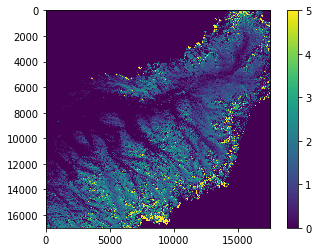

In [6]:
# imshow without flipping
plt.figure()
plt.imshow(ds.snow[5]/1000, vmax=5)
# plt.imshow(ds.snow[5]/1000, origin='lower')
plt.colorbar()
plt.show()

#gets rid of zeros
# d = np.where(ds.snow[5].values>0, ds.snow[5].values, np.nan)
# plt.imshow(d/1000, origin='lower', vmax=5)

#use isel()
# plt.imshow(ds.isel(time=1).snow)

/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent_data_downsize/nc/2013/20130403_SUPERsnow_depth_3m_int.nc


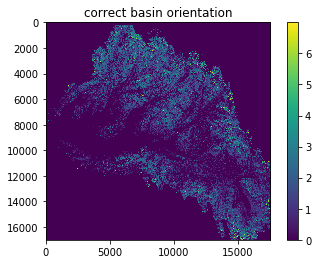

In [7]:
#ONE LIDAR FLIGHT - Flip works!
f = flist[0]
print(f)

ds=xr.open_dataset(f).rename({'Band1':'snow'})
ds.close()

ds['snow'].values=ds.snow[::-1]
plt.imshow(ds.snow/1000)
plt.colorbar()
plt.title('correct basin orientation')
plt.show()

2


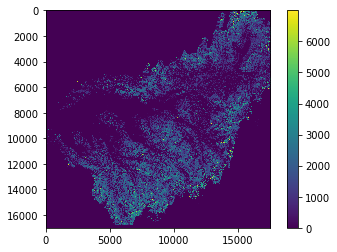

In [8]:
#TWO LIDAR FLIGHT - FLIP DOESN'T WORK
f = flist[0:2]
print(len(f))

ds=xr.open_mfdataset(f, concat_dim='time',combine='nested').rename({'Band1':'snow'})
ds.close()
ds
ds['snow'].values=ds.snow[::-1]
plt.imshow(ds.snow[1])
plt.colorbar()
plt.show()

#### Add TOPO.NC (dem, mask, veg_height)

In [9]:
# open topo.nc
topo = xr.open_dataset(topo_path, drop_variables=['veg_tau','veg_k','veg_type','projection'], chunks={'x':1000, 'y':1000})
topo.close()
topo

<xarray.Dataset>
Dimensions:     (x: 17569, y: 17002)
Coordinates:
  * y           (y) float32 4230327.0 4230324.0 ... 4179327.0 4179324.0
  * x           (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
Data variables:
    veg_height  (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    dem         (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    mask        (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Attributes:
    last_modified:       [2019-08-08 17:17:16] Data added or updated
    Conventions:         CF-1.6
    dateCreated:         2019-08-08 17:17:34
    Title:               Topographic Images for SMRF/AWSM
    history:             [2019-08-08 17:17:34] Create netCDF4 file using Basi...
    institution:         USDA Agricultural Research Service, Northwest Waters...
    generation_command:  /usr/local/bin/basin_setup -f corrected_tuolumne_sub...

In [10]:
#add topo features to lidar DataSet (ds)
ds['dem'] = (['y','x'],topo.dem)
ds['veg'] = (['y','x'],topo.veg_height)
ds['mask'] = (['y','x'],topo.mask)

In [11]:
ds

<xarray.Dataset>
Dimensions:              (time: 2, x: 17569, y: 17002)
Coordinates:
  * x                    (x) float64 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y                    (y) float64 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
Dimensions without coordinates: time
Data variables:
    transverse_mercator  (time) |S1 b'' b''
    snow                 (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dem                  (y, x) float32 2633.369 2635.3313 ... 3064.3577
    veg                  (y, x) float32 0.0 0.0 0.0 0.0 ... 17.5 17.5 17.5 17.5
    mask                 (y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.2.3, released 2017/11/20
    history:             Wed Sep 25 11:53:07 2019: GDAL CreateCopy( /home/meg...

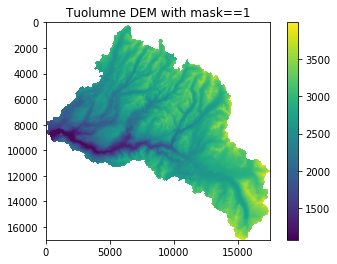

In [19]:
plt.imshow(ds.dem.where(ds.mask==1))
plt.colorbar()
plt.title('Tuolumne DEM with mask==1')
plt.show()

#### ISSUE: different orientations using imshow()

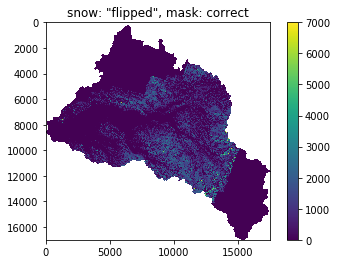

In [15]:
# plot snow with mask (up/down issue)
plt.imshow(ds.snow[0].where(ds.mask==1))
# plt.imshow(ds.snow[0].where(ds.mask==1), origin='lower')
plt.colorbar()
plt.title('snow: "flipped", mask: correct')
plt.show()

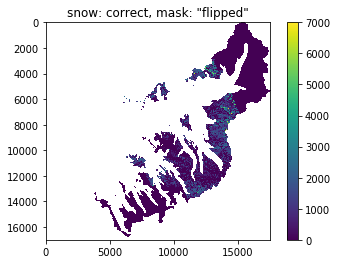

In [16]:
#attemps to get correct orientation
d = ds.isel(time=0).snow.where(ds.dem > 2900).where(ds.mask==1)
plt.imshow(d[::-1,:])
plt.colorbar()
plt.title('snow: correct, mask: "flipped"')
plt.show()
#snow correct, dem upside down

#### Normalized variance for flights closest to peak SWE dates

In [ ]:
# Normalized variance for flights closest to peak SWE dates
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 1). mean snow depth for each year (get 6 means for each year, 2013-2018 (compute without zeros ideally))
d=ds.snow.mean(dim=['x', 'y'])
d

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 2). normalize lidar

# dsn=ds.snow/ds.snow.mean(dim='time')
# dsn


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 3). compute normalized variance for peak SWE dates
# var=ds.snow.var(dim='time')

In [ ]:
plt.figure()
plt.imshow(dsn[4])
plt.colorbar()
plt.show()